In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import re

from scipy import special, optimize

In [2]:
def get_csv(filename, headDrop, tailDrop):
    df = pd.read_csv(filename, header=None, sep='\n');

    # Remove file header (1st 11 rows)
    r = 11;
    for i in range(r):
        df = df.drop([i]);

    # Split columns by commas
    df = df[0].str.split(",", expand=True);

    new_header = df.iloc[0]; #grab the first row for the header
    df = df[1:]; #take the data less the header row
    df.columns = new_header; #set the header row as the df header

    units = df.iloc[0]; # Get units
    df = df.drop([r+1]); # Remove units row from dataframe
    
    df.drop(df.head(headDrop).index, inplace=True) # drop first headDrop rows
    df.drop(df.tail(tailDrop).index, inplace=True) # drop last tailDrop rows
    '''
    if headDrop > 0:
        for i in range(headDrop):
            df = df.drop([r+2+i]);
            
    if tailDrop > 0:
        for i in range(tailDrop):
            df = df.drop([len(df)]);
    '''

    #      [0]    [1]
    return units, df;

### Cross
### $$ \frac{\eta - b}{a - b} = \frac{1}{1 + (c \dot{\gamma})^d} $$
### $$ \eta = \frac{a - b}{1 + (c \dot{\gamma})^d} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [3]:
def Cross_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    deno = 1 + (c*gamma)**d;
    
    return (nume/deno) + b;

### Carreau
### $$ \frac{\eta - b}{a - b} = \left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{d - 1}{2}} $$
### $$ \eta = \frac{a - b}{\left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{1 - d}{2}}} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [4]:
def Carreau_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**2;
    expo = (1 - d)/2;
    deno = base**expo;
    
    return (nume/deno) + b;

### The Carreau-Yasuda Model [1]
### $$ \frac{\eta - b}{a - b} = \frac{1}{\left[1 + \left(c \dot{\gamma}\right)^e\right]^{\frac{1 - d}{e}}} $$
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [5]:
def CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    e = m;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**e;
    expo = (1 - d)/e;
    deno = base**expo;
    
    return (nume/deno) + b;

### Sisko
### $$ \eta = a + b \dot{\gamma}^{c - 1} $$

### where:
$a =$ infinite rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [6]:
def sisko_(gamma, eta_inft, kappa, n):
    a = eta_inft;
    b = kappa;
    c = n;
    
    expo = c - 1;
    
    return a + b*(gamma**expo);

### Williamson
### $$ \eta = \frac{a}{1 + (b \dot{\gamma})^c} $$

### where:
$a =$ zero rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [7]:
def williamson_(gamma, eta_zero, kappa, n):
    a = eta_zero;
    b = kappa;
    c = n;
    
    deno = 1 + (b*gamma)**c;
    
    return a/deno;

---
### Best Fit

In [8]:
def fit_Model_(filename, headDrop, tailDrop, plotname, modelName, eta_zero=0, eta_inft=0, kappa=0, n=0, m=0):
    # get units and Data
    units_df = get_csv(filename, headDrop, tailDrop)[0]
    nSeal_df = get_csv(filename, headDrop, tailDrop)[1]

    # a, b, c, d and e are reasonable initial guesses for EOS parameters

    # Chose what to plot
    x_index = 1; # gamma = Shear rate
    y_index = 2; # eta   = Viscosity

    # Optimization process
    gamma = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float);
    eta   = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float);

    # remove neg values
    gamma = gamma[eta >= 0]
    eta = eta[eta >= 0]

    # Optimize according to the selected modelName
    if modelName == 'Cross':
        p0 = eta_zero, eta_inft, kappa, n;
#         results  = optimize.curve_fit(Cross_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         eta_inft = results[0][1]; # infinite rate viscosity
#         kappa    = results[0][2]; # consistency
#         n        = results[0][3]; # rate index
        eta_fit  = Cross_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'Carreau':
        p0 = eta_zero, eta_inft, kappa, n;
#         results  = optimize.curve_fit(Carreau_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         eta_inft = results[0][1]; # infinite rate viscosity
#         kappa    = results[0][2]; # consistency
#         n        = results[0][3]; # rate index
        eta_fit  = Carreau_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'CarreauYasuda':
        p0 = eta_zero, eta_inft, kappa, n, m;
#         results  = optimize.curve_fit(CarreauYasuda_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         eta_inft = results[0][1]; # infinite rate viscosity
#         kappa    = results[0][2]; # consistency
#         n        = results[0][3]; # rate index
#         m        = results[0][4]; # transition index
        eta_fit  = CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m);
    
    elif modelName == 'Sisko':
        p0 = eta_inft, kappa, n;
#         results  = optimize.curve_fit(sisko_, gamma, eta, p0);
#         eta_inft = results[0][0]; # infinite rate viscosity
#         kappa    = results[0][1]; # consistency
#         n        = results[0][2]; # rate index
        eta_fit  = sisko_(gamma, eta_inft, kappa, n);
    
    elif modelName == 'Williamson':
        p0 = eta_zero, kappa, n;
#         results  = optimize.curve_fit(williamson_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         kappa    = results[0][1]; # consistency
#         n        = results[0][2]; # rate index
        eta_fit  = williamson_(gamma, eta_zero, kappa, n);
    
    else:
        return "modelName shall take a valid value. Use help(fit_Model_) for more details.s"; 

    return gamma, eta_fit, eta_zero, eta_inft

In [9]:
def compareData_wFits_(plotname, filemanes, headDrop, tailDrop, plotlabels, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints=True, plotModel=True):
    
    # Get units
    units_df = get_csv(filemanes[0], headDrop[0], tailDrop[0])[0]
    display(units_df)

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));

    # Chose what to plot
    x_index = 1
    y_index = 2

    # Plot
    for i in range(len(filemanes)):
        y_fit = fit_Model_(
            fileNames[i],
            headDrops[i],
            tailDrops[i],
            fileDescription[i] + " - " + fileNames[i],
            Model[i],
            eta_zero[i],
            eta_inft[i],
            kappa[i],
            n[i],
            m[i]
        );
        
        _0_ps_thf_df = get_csv(filemanes[i], headDrop[i], tailDrop[i])[1]
        x = _0_ps_thf_df.iloc[:, x_index].to_numpy().astype(np.float)
        y = _0_ps_thf_df.iloc[:, y_index].to_numpy().astype(np.float)

        if plotDatapoints: plt.scatter(x, y, s=1);
        # s=(i*4)+2

        if plotModel:
            if Model[i] == 'Sisko':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
            elif Model[i] == 'Williamson':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + ';');
            else:
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
    
    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(_0_ps_thf_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(_0_ps_thf_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 12});
    plt.savefig('plt_' + re.sub('[^A-Za-z0-9]+', '', plotname) + '.png', dpi=300, bbox_inches='tight');
    display(plt);

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

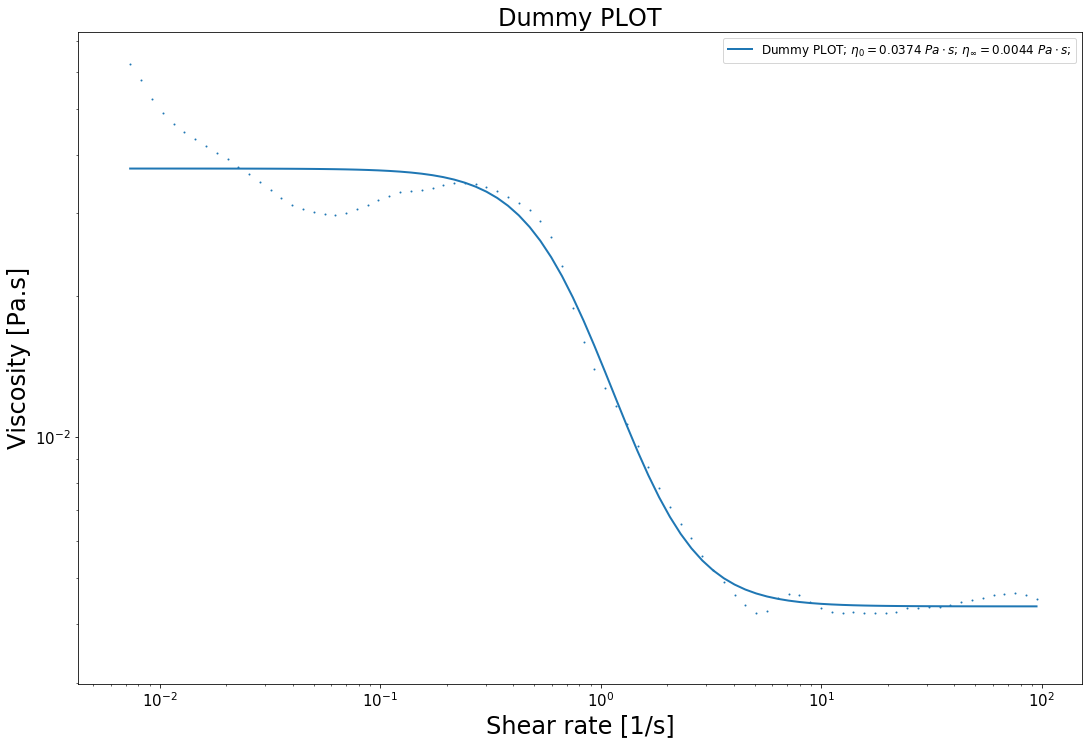

In [10]:
# TESTING FUNCTIONS
plotName        = "Dummy PLOT";
fileNames       = ["./csv/psb_nmp_00_10.csv"];
Model           = [          'CarreauYasuda'];
eta_zero        = [                0.0373544];
eta_inft        = [               0.00435907];
kappa           = [                  1.35666];
n               = [                 -1.45866];
m               = [                  2.30305];
fileDescription = [             "Dummy PLOT"];
headDrops       = [                        1];
tailDrops       = [                        0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints=True)

---
---
# PEO in SU8

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

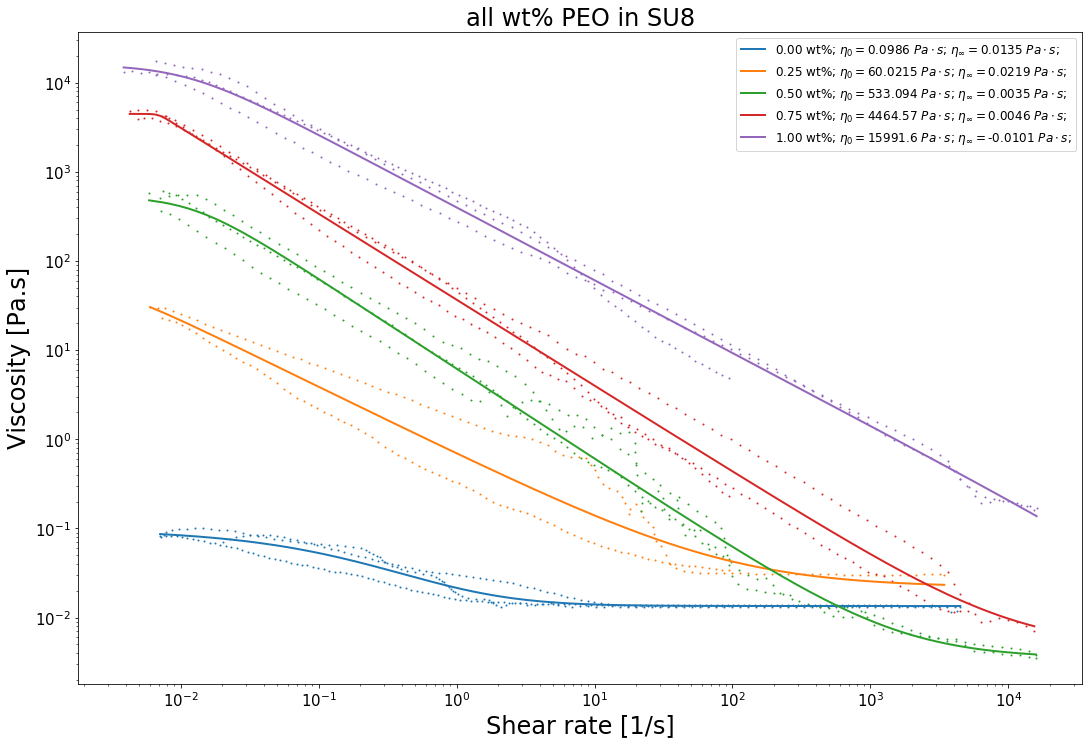

In [11]:
# #####
# plotName        = "0.00 wt% PEO in SU8";
# fileNames       = ["./csv/peo_su8_00_000_0.csv", "./csv/peo_su8_01_000_0.csv", "./csv/peo_su8_01_000_1.csv"];
# Model           = [             'CarreauYasuda',              'CarreauYasuda',              'CarreauYasuda'];
# eta_zero        = [                    0.158976,                     0.223960,                     0.100210];
# eta_inft        = [                   0.0122739,                    0.0137573,                    0.0132750];
# kappa           = [                    0.825273,                0.00000056265,                   0.00803073];
# n               = [                   -0.175665,                     -64.4259,                     -86.0240];
# m               = [                    0.366622,                     0.278670,                     0.781939];
# fileDescription = [                  "0.00 wt%",                   "0.00 wt%",                   "0.00 wt%"];
# headDrops       = [                          10,                            1,                            0];
# tailDrops       = [                           0,                            2,                            0];

# # Plot all files in one plot
# compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

# #####
# plotName        = "0.25 wt% PEO in SU8";
# fileNames       = ["./csv/peo_su8_00_025_0.csv", "./csv/peo_su8_01_025_0.csv"];
# Model           = [             'CarreauYasuda',                    'Carreau'];
# eta_zero        = [                     22.7737,                      21.1784];
# eta_inft        = [                   0.0296728,                    0.0208298];
# kappa           = [                     129.269,                      24.4660];
# n               = [                    0.106211,                     0.168704];
# m               = [                     75.4193,                         None];
# fileDescription = [                  "0.25 wt%",                   "0.25 wt%"];
# headDrops       = [                           0,                            0];
# tailDrops       = [                           0,                            0];

# # Plot all files in one plot
# compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

# #####
# plotName        = "0.50 PEO wt% in SU8";
# fileNames       = ["./csv/peo_su8_00_050_0.csv", "./csv/peo_su8_01_050_0.csv", "./csv/peo_su8_01_050_1.csv"];
# Model           = [                   'Carreau',                    'Carreau',                    'Carreau'];
# eta_zero        = [                     754.109,                      539.885,                      499.148];
# eta_inft        = [                  -0.0211843,                   0.00265071,                   0.00409813];
# kappa           = [                     121.053,                      180.600,                      36.0952];
# n               = [                  -0.0104125,                    0.0818644,                    -0.109133];
# m               = [                        None,                         None,                         None];
# fileDescription = [                  "0.50 wt%",                   "0.50 wt%",                   "0.50 wt%"];
# headDrops       = [                           0,                            0,                            0];
# tailDrops       = [                           0,                            0,                            0];

# # Plot all files in one plot
# compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

# #####
# plotName        = "0.75 wt% PEO in SU8";
# fileNames       = ["./csv/peo_su8_00_075_0.csv", "./csv/peo_su8_01_075_0.csv", "./csv/peo_su8_01_075_1.csv"];
# Model           = [                   'Carreau',              'CarreauYasuda',              'CarreauYasuda'];
# eta_zero        = [                     4414.60,                      4000.16,                      4910.67];
# eta_inft        = [                    0.129166,                   0.00545168,                   0.00503852];
# kappa           = [                     93.0346,                      157.542,                      160.027];
# n               = [                  -0.0468757,                   0.00398974,                     0.109703];
# m               = [                        None,                      52.2362,                      48.2246];
# fileDescription = [                  "0.75 wt%",                   "0.75 wt%",                   "0.75 wt%"];
# headDrops       = [                           0,                            0,                            0];
# tailDrops       = [                           0,                            0,                            0];

# # Plot all files in one plot
# compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

# #####
# plotName        = "1.00 wt% PEO in SU8";
# fileNames       = ["./csv/peo_su8_00_100_0.csv", "./csv/peo_su8_01_100_0.csv", "./csv/peo_su8_01_100_1.csv"];
# Model           = [                   'Carreau',              'CarreauYasuda',              'CarreauYasuda'];
# eta_zero        = [                     11480.3,                      13040.9,                      16597.3];
# eta_inft        = [                    0.049438,                    -0.102783,                   -0.0263914];
# kappa           = [                     38.0288,                      162.312,                      70.5330];
# n               = [                    0.125853,                     0.254497,                     0.169349];
# m               = [                        None,                      48.1761,                      3.85102];
# fileDescription = [                  "1.00 wt%",                   "1.00 wt%",                   "1.00 wt%"];
# headDrops       = [                           0,                            0,                            0];
# tailDrops       = [                           0,                            0,                            0];

# # Plot all files in one plot
# compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

#####
plotName        = "all wt% PEO in SU8";
fileNames       = ["./csv/peo_su8_all_000.csv", "./csv/peo_su8_all_025.csv", "./csv/peo_su8_all_050.csv", "./csv/peo_su8_all_075.csv", "./csv/peo_su8_all_100.csv"];
Model           = [            'CarreauYasuda',                   'Carreau',                   'Carreau',             'CarreauYasuda',             'CarreauYasuda'];
eta_zero        = [                  0.0986148,                     60.0215,                     533.094,                     4464.57,                     15991.6];
eta_inft        = [                  0.0134786,                   0.0218821,                  0.00350675,                  0.00464033,                  -0.0100825];
kappa           = [                    2.59078,                     373.190,                     82.3492,                     144.815,                     91.8066];
n               = [                  -0.474137,                    0.242361,                  -0.0105593,                   0.0353161,                    0.183502];
m               = [                   0.660423,                        None,                        None,                     19.2880,                     1.70415];
fileDescription = [                 "0.00 wt%",                  "0.25 wt%",                  "0.50 wt%",                  "0.75 wt%",                  "1.00 wt%"];
headDrops       = [                          0,                           0,                           0,                           0,                           0];
tailDrops       = [                          0,                           0,                           0,                           0,                           0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

---
# PS in THF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

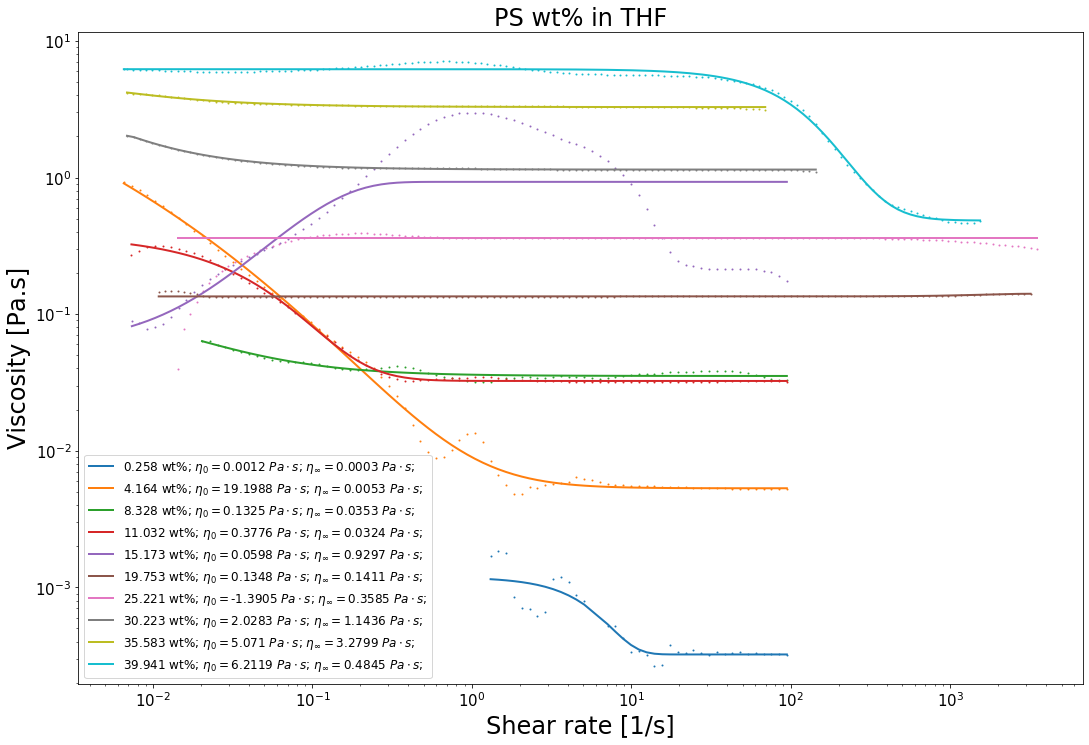

In [12]:
plotName  = "PS wt% in THF";
fileNames = [
    "./csv/ps_thf_00_0.csv",
    "./csv/ps_thf_00_1.csv",
    "./csv/ps_thf_00_2.csv",
    "./csv/ps_thf_00_3.csv",
    "./csv/ps_thf_00_4.csv",
    "./csv/ps_thf_01_0.csv",
    "./csv/ps_thf_01_1.csv",
    "./csv/ps_thf_01_2.csv",
    "./csv/ps_thf_01_3.csv",
    "./csv/ps_thf_01_4.csv"
];
Model = [
    'Carreau',
    'CarreauYasuda',
    'Cross',
    'CarreauYasuda',
    'CarreauYasuda',
    'Carreau',
    'CarreauYasuda',
    'CarreauYasuda',
    'Carreau',
    'CarreauYasuda'
];
eta_zero = [
    0.00118637,
    19.1988,
    0.132498,
    0.377618,
    0.0597679,
    0.134773,
    -1.39046,
    2.02834,
    5.07105,
    6.21190
];
eta_inft = [
    0.000322408,
    0.00530989,
    0.0352518,
    0.0324093,
    0.929694,
    0.141063,
    0.358452,
    1.14362,
    3.27995,
    0.484481
];
kappa = [
    0.00612781,
    2.09116,
    119.844,
    4.91226,
    0.261838,
    -0.0000391132,
    8.53515,
    140.175,
    307.979,
    0.00412472
];
n = [
    -1471.44,
    -1.80657,
    1.00859,
    -3.96417,
    -145.279,
    -540.112,
    -4.20664,
    0.0456654,
    0.206777,
    -3.74005
];
m = [
    None,
    0.260101,
    None,
    1.00879,
    1.33833,
    None,
    0.0667805,
    32.2787,
    None,
    1.57402
];
fileDescription = [
    "0.258 wt%",
    "4.164 wt%",
    "8.328 wt%",
    "11.032 wt%",
    "15.173 wt%",
    "19.753 wt%",
    "25.221 wt%",
    "30.223 wt%",
    "35.583 wt%",
    "39.941 wt%"
];
headDrops = [47, 0,   10, 1, 1,  6,  9,  1,    1,  0];
tailDrops = [ 0, 0,    0, 0, 0, 18, 17, 52,   60, 26];
a         = [10, 2, 1000, 1, 1, 80, 100, 1, 1000, 47];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
# PSB in NMP

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

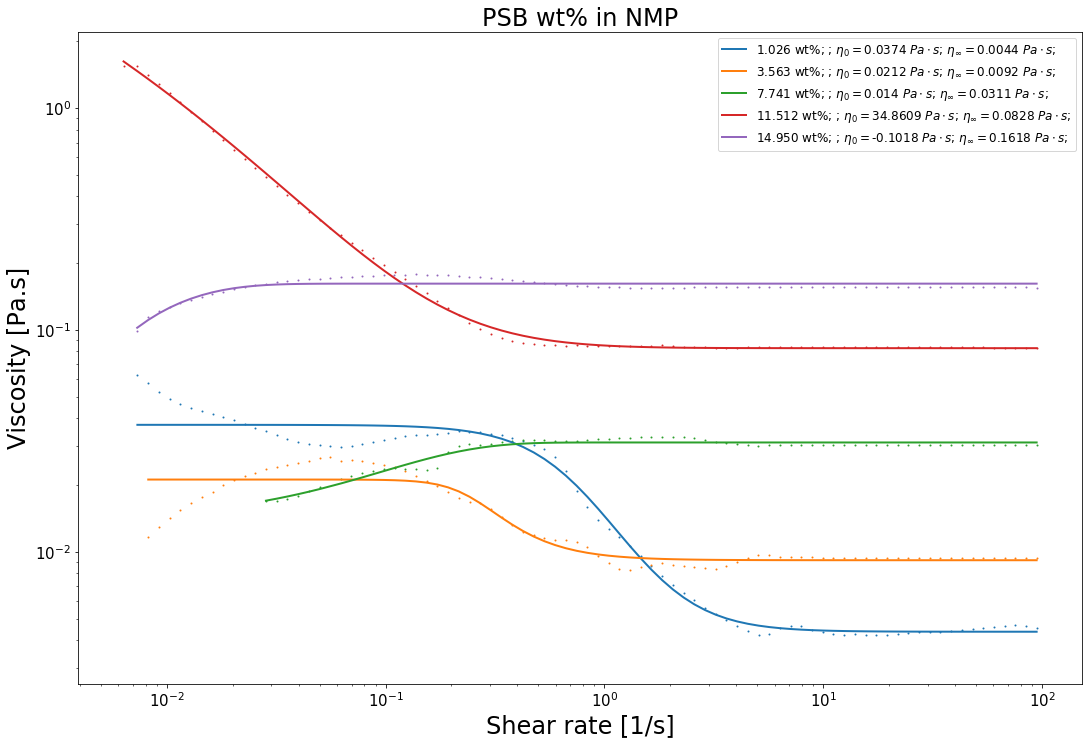

In [13]:
plotName  = "PSB wt% in NMP";
fileNames = [
    "./csv/psb_nmp_00_10.csv",
    "./csv/psb_nmp_00_11.csv",
    "./csv/psb_nmp_00_12.csv",
    "./csv/psb_nmp_00_13.csv",
    "./csv/psb_nmp_00_14.csv"
];
Model = [
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda'
];
eta_zero = [
    0.0373544,
    0.0211631,
    0.0139824,
    34.8609,
    -0.101783
];
eta_inft = [
    0.00435907,
    0.00915773,
    0.0311029,
    0.0827903,
    0.161776
];
kappa = [
    1.35666,
    4.15157,
    0.0371662,
    0.0277821,
    2.50066
];
n = [
    -1.45866,
    -1.24582,
    -414.728,
    -5.86097,
    -43.2607
];
m = [
    2.30305,
    4.64510,
    1.10484,
    0.246714,
    0.877050
];
fileDescription = [
    "1.026 wt%; ",
    "3.563 wt%; ",
    "7.741 wt%; ",
    "11.512 wt%; ",
    "14.950 wt%; "
];
headDrops = [   1, 2,  13,   0, 1];
tailDrops = [   0, 0,   0,   0, 0];
a         = [1000, 1, 100, 500, 1];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
# PSB in THF and DMF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

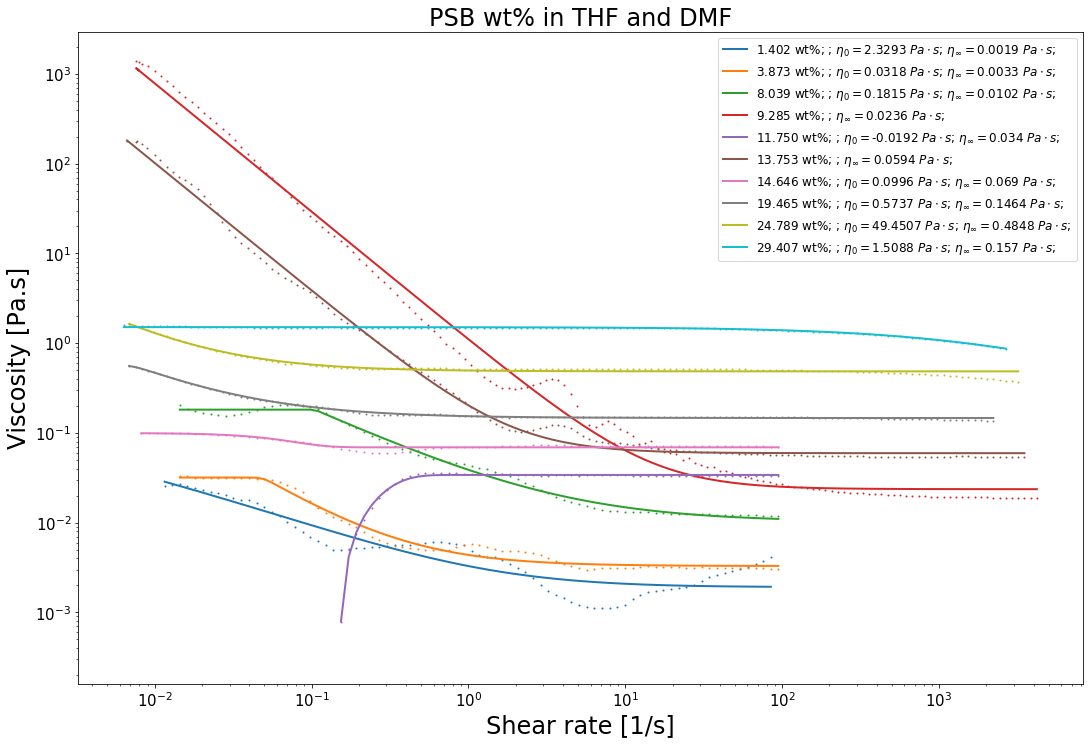

In [14]:
plotName  = "PSB wt% in THF and DMF";
fileNames = [
    "./csv/PSB_THFDMF_00_5.csv",
    "./csv/PSB_THFDMF_00_6.csv",
    "./csv/PSB_THFDMF_00_7.csv",
    "./csv/PSB_THFDMF_01_5.csv",
    "./csv/PSB_THFDMF_00_8.csv",
    "./csv/PSB_THFDMF_01_6.csv",
    "./csv/PSB_THFDMF_00_9.csv",
    "./csv/PSB_THFDMF_01_7.csv",
    "./csv/PSB_THFDMF_01_8.csv",
    "./csv/PSB_THFDMF_01_9.csv"
];
Model = [
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda',
    'Sisko',
    'CarreauYasuda',
    'Sisko',
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda'
];
eta_zero = [
    2.32935,
    0.0317900,
    0.181529,
    None,
    -0.0191586,
    None,
    0.0996140,
    0.573659,
    49.4507,
    1.50881
];
eta_inft = [
    0.00191153,
    0.00328468,
    0.0102345,
    0.0235842,
    0.0339812,
    0.0594043,
    0.0690308,
    0.146416,
    0.484796,
    0.156964
];
kappa = [
    0.00524417,
    20.4787,
    9.54913,
    1.08314,
    0.244787,
    0.143412,
    0.656996,
    140.187,
    7700.62,
    0.000446048
];
n = [
    -1.45873,
    -0.0834501,
    0.205762,
    -0.430100,
    -326.661,
    -0.425481,
    -490.380,
    0.168640,
    0.0561578,
    0.403383
];
m = [
    0.133286,
    23.7978,
    104.292,
    None,
    1.81448,
    None,
    1.84387,
    10.5005,
    47.9260,
    0.703678
];
fileDescription = [
    "1.402 wt%; ",
    "3.873 wt%; ",
    "8.039 wt%; ",
    "9.285 wt%; ",
    "11.750 wt%; ",
    "13.753 wt%; ",
    "14.646 wt%; ",
    "19.465 wt%; ",
    "24.789 wt%; ",
    "29.407 wt%; "
];
headDrops = [ 5, 7,   7,  1,  28,   1, 2,   1,  1,  0];
tailDrops = [ 1, 0,   0, 15,   0,  17, 0,  22, 18, 20];
a         = [10, 1, 500,  1, 200, 900, 1000, 700,  1,  1];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
# PSMS in DMF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

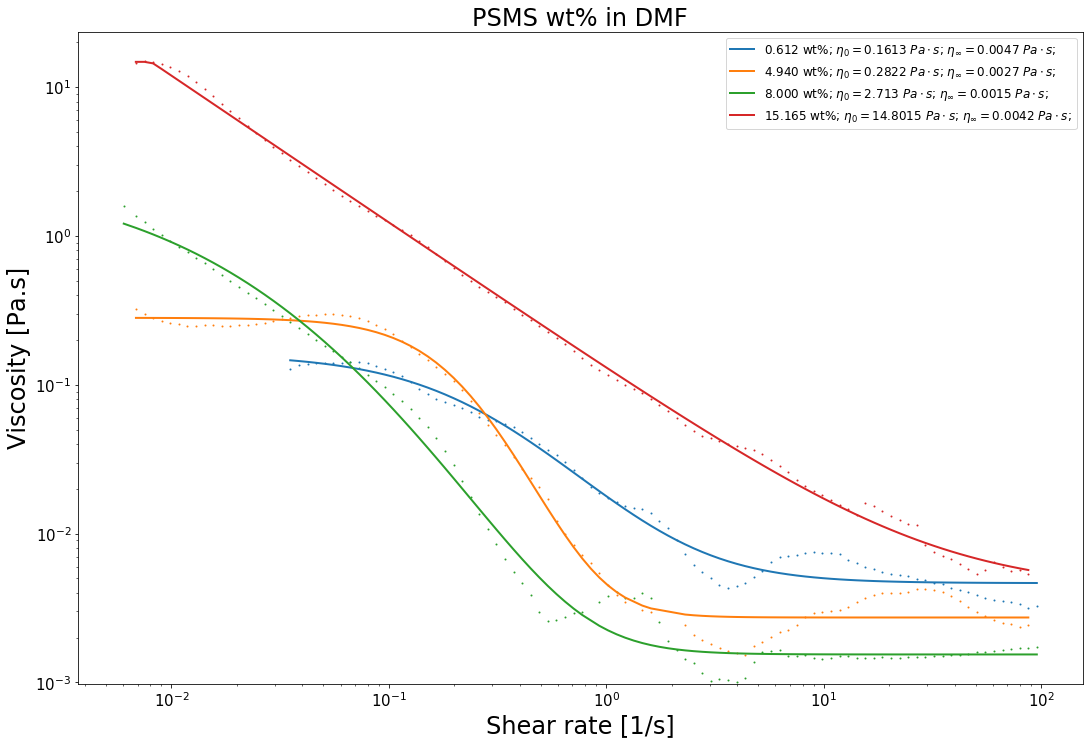

In [15]:
plotName  = "PSMS wt% in DMF";
fileNames = [
    "./csv/psms_dmf_00_6.csv",
    "./csv/psms_dmf_00_7.csv",
    "./csv/psms_dmf_00_8.csv",
#     "./csv/psms_dmf_00_9.csv",
    "./csv/psms_dmf_00_10.csv"
];
Model = [
    'CarreauYasuda',
    'CarreauYasuda',
    'CarreauYasuda',
#     'CarreauYasuda',
    'CarreauYasuda'
];
eta_zero = [
    0.161264,
    0.282163,
    2.71305,
#     0.0348387,
    14.8015
];
eta_inft = [
    0.00465213,
    0.00273374,
    0.00154317,
#     0.0736613,
    0.00416426
];
kappa = [
    3.97780,
    4.50601,
    19.2024,
#     0.851170,
    123.939
];
n = [
    -0.641457,
    -2.27904,
    -1.61674,
#     -7.21069,
    0.0124974
];
m = [
    1.27503,
    2.03869,
    0.677510,
#     9.75580,
    76.4016
];
fileDescription = [
    "0.612 wt%",
    "4.940 wt%",
    "8.000 wt%",
#     "11.431 wt%",
    "15.165 wt%"
];
# headDrops = [18, 1, 0, 3, 0];
# tailDrops = [ 0, 1, 0, 0, 1];
headDrops = [18, 1, 0, 0];
tailDrops = [ 0, 1, 0, 1];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
# PVK in CHL

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

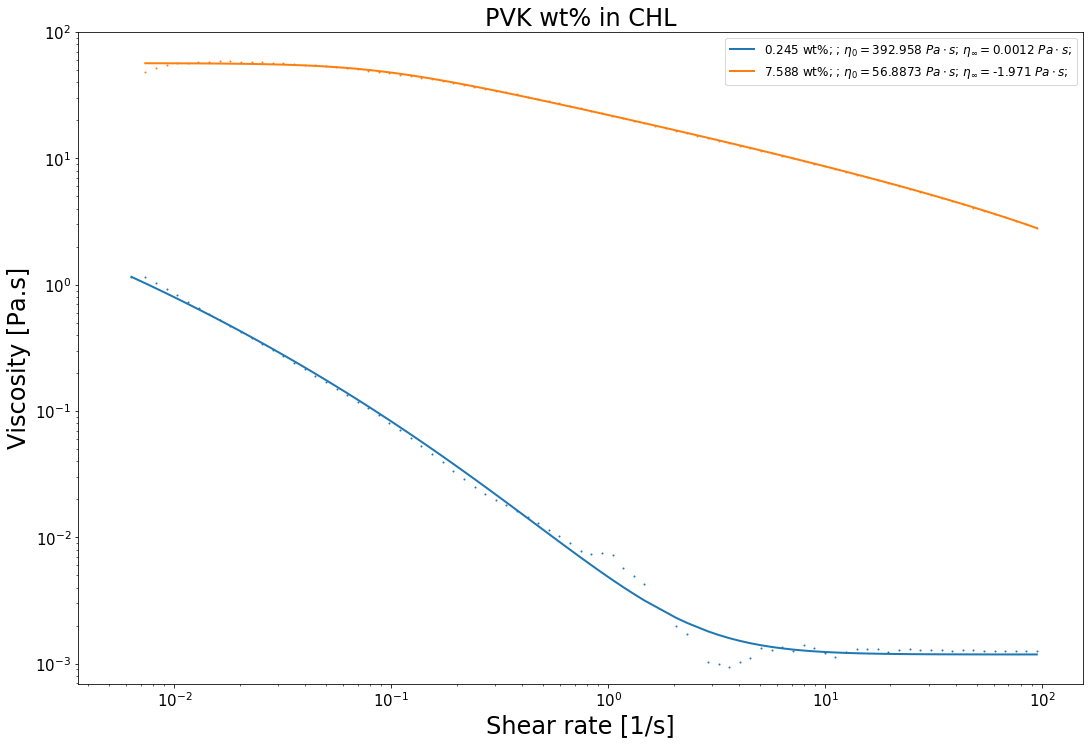

In [16]:
plotName  = "PVK wt% in CHL";
fileNames = [
    "./csv/pvk_chl_00_0.csv",
    "./csv/pvk_chl_00_1.csv"
];
Model = [
    'CarreauYasuda',
    'CarreauYasuda'
];
eta_zero = [
    392.958,
    56.8873
];
eta_inft = [
    0.00118019,
    -1.97103
];
kappa = [
    0.00000000000537138,
    12.3120
];
n = [
    -55.3424,
    0.644423
];
m = [
    0.137014,
    1.96570
];
fileDescription = [
    "0.245 wt%; ",
    "7.588 wt%; "
];
headDrops = [ 1, 1];
tailDrops = [ 0, 0];
a         = [10, 1];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
# PVK in DCM

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

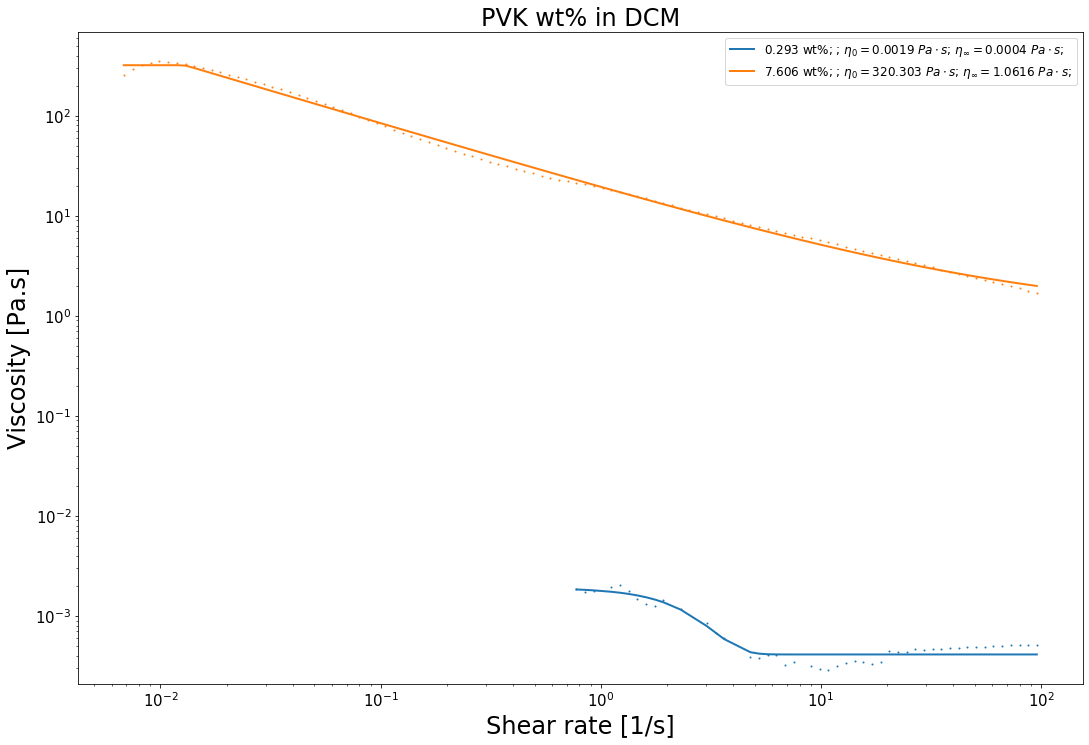

In [17]:
plotName  = "PVK wt% in DCM";
fileNames = [
    "./csv/pvk_dcm_00_3.csv",
    "./csv/pvk_dcm_00_4.csv"
];
Model = [
    'CarreauYasuda',
    'CarreauYasuda'
];
eta_zero = [
    0.00190737,
    320.303
];
eta_inft = [
    0.000412091,
    1.06162
];
kappa = [
    0.0391502,
    77.5342
];
n = [
    -669.043,
    0.344518
];
m = [
    2.47810,
    79.6529
];
fileDescription = [
    "0.293 wt%; ",
    "7.606 wt%; "
];
headDrops = [  53, 1];
tailDrops = [   0, 0];
a         = [1000, 1];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
# Standard Conforming to ASTM Oil Standard

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

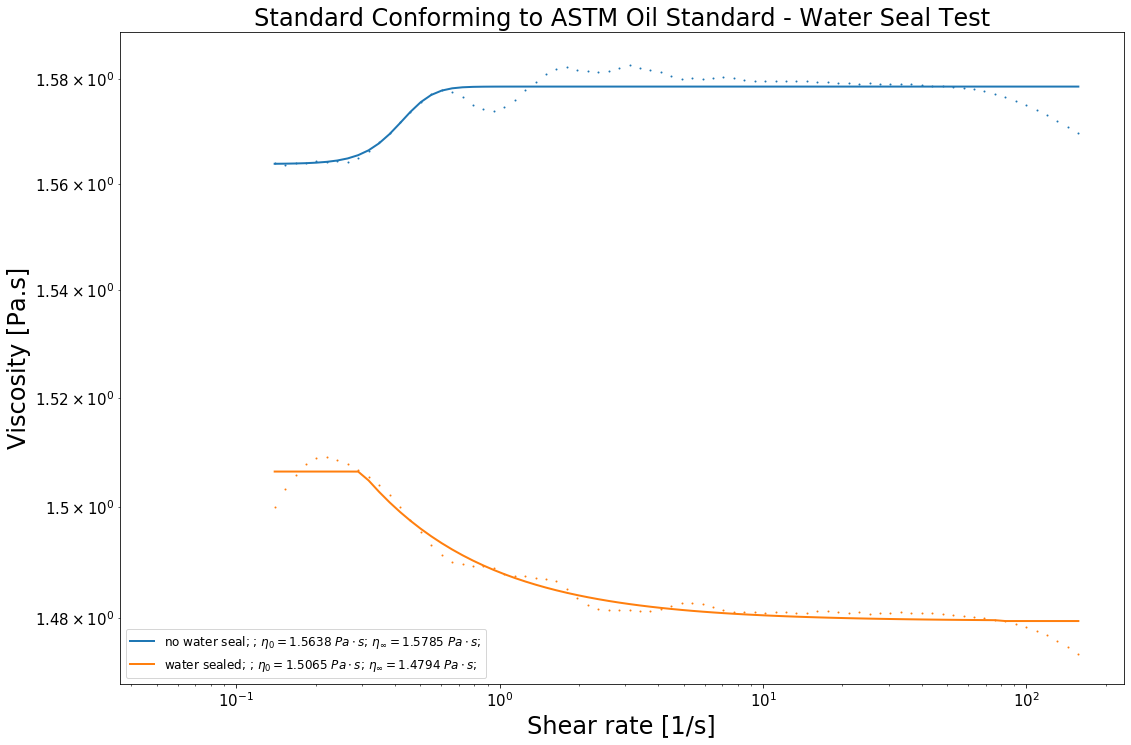

In [18]:
plotName  = "Standard Conforming to ASTM Oil Standard - Water Seal Test";
fileNames = [
    "./csv/std_noseal.csv",
    "./csv/std_sealed.csv"
];
Model = [
    'CarreauYasuda',
    'CarreauYasuda'
];
eta_zero = [
    1.56377,
    1.50646
];
eta_inft = [
    1.57853,
    1.47937
];
kappa = [
    2.03980,
    3.36134
];
n = [
    -10.4543,
    0.0696546
];
m = [
    5.41514,
    128.111
];
fileDescription = [
    "no water seal; ",
    "water sealed; "
];
headDrops = [34, 34];
tailDrops = [51, 51];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)